<a href="https://colab.research.google.com/github/EauDeData/EauDeData.github.io/blob/master/docencia/MPiHD/practica_fotografia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pràctica Processat de Fotografía
## Métodes de visió per computador en el contexte de la imatge de la fotografia histórica

Per poder visualitzar tots els continguts interactius de l'exercici, premeu el botó "play" a l'esquerra de cada cel·la en ordre. Si heu arribat a través d'un enllaç, segurament haureu de "guardar una cópia" a la pestanya d'arxiu.

Qualsevol dubte podeu escriure amolina@cvc.uab.cat

Intenteu donar resposta a cadascuna de les questions de forma detallada i fent referència tant al material exposat com a part teórica com al material del propi exercici.

In [1]:
#@title
!pip install transformers > ext.txt
!pip install timm > ext.txt
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils import contours
import random
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import scipy.ndimage as ndim
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

from transformers import DetrFeatureExtractor, DetrForObjectDetection
import torch
from PIL import Image
import requests
import timm
import os

In [2]:
#@title
!mkdir content
!curl https://eaudedata.github.io/docencia/MPiHD/contingut/imatges/horses.jpg -o content/horses.jpg
!curl https://eaudedata.github.io/docencia/MPiHD/contingut/cataleg/master-pnp-prok-01000-01047u.tif -o content/rgb.tif
!curl https://eaudedata.github.io/docencia/MPiHD/contingut/cataleg/car.jpg -o content/car.jpg
!curl https://eaudedata.github.io/docencia/MPiHD/contingut/cataleg/ski.jpg -o content/ski.jpg
!curl https://eaudedata.github.io/docencia/MPiHD/contingut/cataleg/tenis2.jpg -o content/tenis2.jpg
!curl https://eaudedata.github.io/docencia/MPiHD/contingut/cataleg/espectacle.jpg -o content/espectacle.jpg
!curl https://eaudedata.github.io/docencia/MPiHD/contingut/cataleg/teatre.jpg -o content/tenis.jpg
!curl https://eaudedata.github.io/docencia/MPiHD/contingut/cataleg/tenis.jpg -o content/tenis.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34602  100 34602    0     0   199k      0 --:--:-- --:--:-- --:--:--  199k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34.4M  100 34.4M    0     0  54.5M      0 --:--:-- --:--:-- --:--:-- 54.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   98k  100   98k    0     0   874k      0 --:--:-- --:--:-- --:--:--  874k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 59175  100 59175    0     0   577k      0 --:--:-- --:--:-- --:--:--  572k
  % Total    % Received % Xferd  Average Speed   Tim

In [3]:
#@title

def imread(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)
def visualize_image(img):
    
    if len(img) == 2:
        
        fig, axs = plt.subplots(1, 2, figsize = (16, 32))
        axs[0].imshow(img[0], cmap = 'gray')
        axs[0].axis('off')
        
        axs[1].imshow(img[1], cmap = 'gray')
        axs[1].axis('off')
        
        plt.box(on=None)
        plt.show()
        
        return None
    
    plt.imshow(img, cmap = 'gray')
    plt.axis('off')
    plt.box(on=None)
    plt.show()
    


## Eines per detecció d'objectes

#### Objectiu: Concatena operacions sobre la següent imatges per tant de poder localitzar els diferents objectes de l'escena. Respon les preguntes i raona l'efectivitat de la teva decisió en quant els valors i operacions escollits.
<img src="https://eaudedata.github.io/docencia/MPiHD/contingut/imatges/horses.jpg">


>

In [4]:
#@title
THR_VALUE = 75
MIN_SIZE = 100
SOBEL_SIZE = 5
def threshold(img):
    global THR_VALUE
    return cv2.threshold(img, THR_VALUE, 255, cv2.THRESH_BINARY_INV)[1]

def contours_sobel(img):
    
    scale = 1
    delta = 0
    
    grad_x = cv2.Sobel(img, -1, 1, 0, ksize=SOBEL_SIZE, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    # Gradient-Y
    # grad_y = cv.Scharr(gray,ddepth,0,1)
    grad_y = cv2.Sobel(img, -1, 0, 1, ksize=SOBEL_SIZE, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    
    
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    
    
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    
    return grad

def avg_blur(img):
    kernel = np.ones((5,5),np.float32)/25
    return cv2.filter2D(img,-1,kernel)

def detect(image, pipeline = []):
    
    global MIN_SIZE
    
    base = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)
    
    for f in pipeline:
        image = f(image)
    
    cnts, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if not len(cnts): return base, image
    for n, c in enumerate(cnts):
        if hierarchy[0][n][-1] != -1: continue
        x,y,w,h = cv2.boundingRect(c)
        if w*h < MIN_SIZE: continue
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        cv2.rectangle(base, (x, y), (x + w, y + h), color, 5)
    return base, image

In [5]:
#@title
inim = imread('content/horses.jpg')

In [6]:
#@title
thr = widgets.IntSlider(
    value=120,
    min=0,
    max=255,
    step=1,
    description='Threshold Range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

size = widgets.IntSlider(
    value=1,
    min=1,
    max=500,
    step=1,
    description='Min Size Detected:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

sobel_size = widgets.IntSlider(
    value=1,
    min=1,
    max=30,
    step=1,
    description= 'Sobel Size:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

pos1 = widgets.ToggleButtons(
    options=['threshold', 'average blur', 'sobel', 'None'],
    description='Operation #1:',
    disabled=False,
    button_style='',
)

pos2 = widgets.ToggleButtons(
    options=['threshold', 'average blur', 'sobel', 'None'],
    description='Operation #2:',
    disabled=False,
    button_style='',
)

pos3 = widgets.ToggleButtons(
    options=['threshold', 'average blur', 'sobel', 'None'],
    description='Operation #3:',
    disabled=False,
    button_style='',
)

button = widgets.Button(description="Llença Experiment")
output = widgets.Output()


def selector2function(string):
    if string == 'threshold': return threshold
    if string == 'average blur': return avg_blur
    if string == 'sobel': return contours_sobel
    return lambda x: x
    

def button_click(b):
    
    with output:
        clear_output()
        pipeline = [selector2function(x.value) for x in [pos1, pos2, pos3]]
        global THR_VALUE 
        THR_VALUE= thr.value
        global MIN_SIZE 
        MIN_SIZE = size.value
        global SOBEL_SIZE 
        SOBEL_SIZE = sobel_size.value
        if SOBEL_SIZE %2 == 0: SOBEL_SIZE += 1

        base, im = detect(inim, pipeline=pipeline)
        visualize_image([base, im])
    return None

print("Hyperparameters:\n")
display(thr, size, sobel_size)
print("\nFirst Operation:")
display(pos1)
display(pos2)
display(pos3)
print("\n")
display(button, output)
button_click(button)
button.on_click(button_click)


Hyperparameters:



IntSlider(value=120, continuous_update=False, description='Threshold Range:', max=255)

IntSlider(value=1, continuous_update=False, description='Min Size Detected:', max=500, min=1)

IntSlider(value=1, continuous_update=False, description='Sobel Size:', max=30, min=1)


First Operation:


ToggleButtons(description='Operation #1:', options=('threshold', 'average blur', 'sobel', 'None'), value='thre…

ToggleButtons(description='Operation #2:', options=('threshold', 'average blur', 'sobel', 'None'), value='thre…

ToggleButtons(description='Operation #3:', options=('threshold', 'average blur', 'sobel', 'None'), value='thre…

Button(description='Llença Experiment', style=ButtonStyle())

Output()

### Preguntes:

- Quina és la 'pipeline' (operacions a fer) i la combinació de paràmetres més òptima?

- Què pasa si fem un numero parell de "thresholds"? Per què?

- Quin efecte té el paràmetre "sobel size"?

## Detecció de punts clau
Objectiu: Durant els segles XIX i XX el fotógraf rus Sergey Mikhaylovich va produir una sèrie de fotografies aparentment sencilles, però amb una particularitat:
Sobre un mateix camp visual, es fotografiava amb un filtre vermell (*R*ed), verd (*G*reen) i blau (*B*lue).

In [7]:
#@title
img = imread('content/rgb.tif')

In [8]:
#@title
B = (img[:3218, :]) / 255
G = (img[3219:3219*2-1, :]) / 255
R = (img[3219*2:(3219*3), :]) / 255

Les diferents imatges, en ser monocromatiques es veuen de la següent manera. Tinguem en consideració que aquesta escala de grisos no s'asigna a tot l'espectre visible com estem acostumats, sino únicament a una part.

### Preguntes:

* A quina part de l'espectre visible fa referència aquesta escala de grisos?
* Com obtindries aquestes tres imatges amb una càmera que transformi tot l'espectre visible en una escala de grisos? 

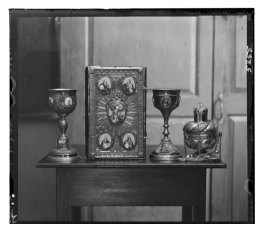

In [9]:
#@title
visualize_image(B)

Nogensmenys les imatges no estan perectament alineades, superposarles asumint que les capes estan colocades com corresponen provoca el següent:

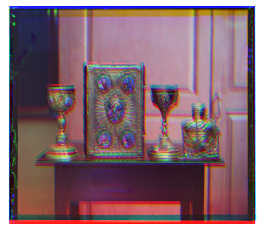

In [10]:
#@title
plt.imshow(np.stack([R, G, B]).transpose(1, 2, 0))
plt.axis('off')
plt.show()

In [11]:
#@title
def sobel(img):
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    return sobelx + sobely

def normalize(img):
    tmp = img - img.min()
    tmp = tmp / tmp.max()
    return tmp


def mat_max(img):
    return np.unravel_index(img.argmax(), img.shape)

def uint8(img):
  return img.astype(np.uint8)

In [12]:
#@title
def match_template(red, green, blue): #EXTRA 2
    gs = sobel(green)
    rs = sobel(red)
    bs = sobel(blue)
    w, h = green.shape
    size = w//8 #o 6
    tl_template = (w//2 - size, h//2 - size)
    template = uint8(gs[w//2 - size:w//2 + size, h//2 - size:h//2 + size])
    red_shift = cv2.matchTemplate(uint8(rs), template, cv2.TM_CCOEFF)
    _, _, _, tl_red = cv2.minMaxLoc(red_shift)
    blue_shift = cv2.matchTemplate(uint8(bs), template, cv2.TM_CCOEFF)
    _, _, _, tl_blue = cv2.minMaxLoc(blue_shift)
    r_shift = (-(tl_red[1] - tl_template[0]), -(tl_red[0] - tl_template[1]))
    b_shift = (-(tl_blue[1] - tl_template[0]), -(tl_blue[0] - tl_template[1]))
    new_red = normalize(ndim.shift(red, r_shift))
    new_blue = normalize(ndim.shift(blue, b_shift))
    new_color = np.array([new_red, green, new_blue]).transpose((1, 2, 0))
    return new_color, red_shift, blue_shift, template

In [13]:
#@title

result, rs, bs, template = match_template(R, G, B)

In [14]:
#@title
rs = (normalize(rs) * 255).astype(np.uint8)
bs = (normalize(bs) * 255).astype(np.uint8)


hq_rs = cv2.equalizeHist(rs)
hq_bs = cv2.equalizeHist(bs)

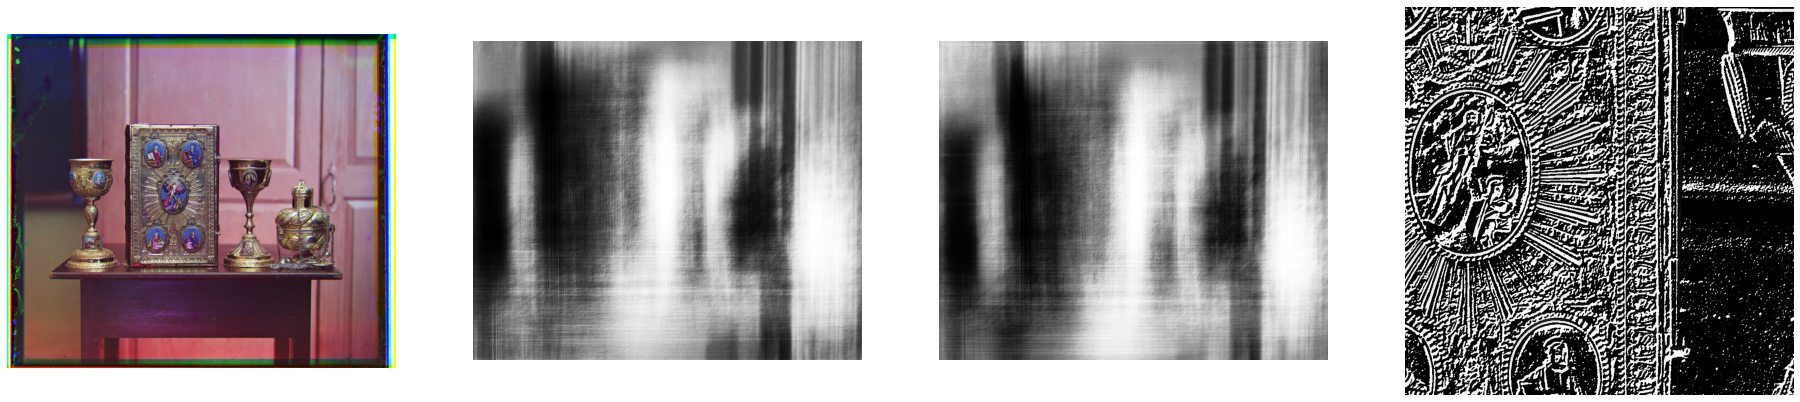

In [15]:
#@title
fig, axs = plt.subplots(1, 4, figsize = (32, 8))
def fill_ax(ax, img):
    if img.shape[-1] == 3:
        ax.imshow(img)
    else:
        ax.imshow(img, cmap = 'gray')
    ax.axis('off')
    

fill_ax(axs[0], result)
fill_ax(axs[1], hq_rs)
fill_ax(axs[2], hq_bs)
fill_ax(axs[3], template)
plt.show()

### Preguntes: 

* Aprofitant la informació a la dreta del resultat, quin procès (concatenació d'operacions) creus que s'ha utilitzat per generar la imatge en color? 
* Quines altres maneres trobes de fer-ho?
* Qué representa la última imatge (dreta)?


## Creació Automàtic d'un Catàleg d'Imatges
#### Conceptes a incorporar: Catàleg d'imatges, classificació d'imatges, caracterització de punts clau....

En aquest apartat crearem un petit i molt naive catàleg d'imatges basant-nos en algorismes de visió i aprenentatge computacional clàssics com els vistos a teoria.

Per catalogar imatges intentarem trobar diferents objectes dins les fotografies i categoritzar-los en un número finit de categories.

Per començar, estableix els paràmetres que consideris adients per la tasca de detecció. 

**TIP:** Recorda executar (botó "play") la cel·la dels paràmetres a cada canvi que facis, d'altre manera no es configurarà com vulguis i s'utilitzaran els paràmetres per defecte.


In [16]:
#@title
def generic_detector(image):
    
    MIN_SIZE = 500 #@param {type:"integer"}
    THR_VALUE = 80#@param {type:"integer"}
    SOBEL_SIZE = 29#@param {type:"integer"}

    
    base = image.copy()
    
    for f in [avg_blur, threshold, contours_sobel]:
        image = f(image)
    
    cnts, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if not len(cnts): return base, image
    images = []
    bbxs = []
    for n, c in enumerate(cnts):
        if hierarchy[0][n][-1] != -1: continue
        x,y,w,h = cv2.boundingRect(c)
        if w*h < MIN_SIZE: continue
        images.append(base[ y:y+h, x:x+w])
        bbxs.append((y, y+h, x, x+w))
    return images, bbxs
  

def descriptor(img):
  alg = cv2.SIFT_create()
  kps =alg.detect(img)
  if len(kps) < 32: return None
  kps = sorted(kps, key=lambda x: -x.response)[:32]
  kps, dsc = alg.compute(img, kps)
  dsc = dsc.flatten()
  return dsc

### Preguntes

En la següent figura observem una sèrie de punts en un pla; investiga que volen dir aquests punts responent les següents preguntes:

* Observem que s'indica que és un conjunt de característiques (features). Tenint en compte que el nombre de punts és molt major al nombre de fotografies a la col·lecció, a qué es corresponen cadascun dels punts de la figura?

* Investiga sobre el que vol dir "projecció PCA", per qué és útil en aquest contexte? Per qué s'ha utilitzat?

* Visita la següent [visualització d'una col·lecció de fotografies](https://eaudedata.github.io/recerca/visualitzador/www/#3/-68.63/106.25). Aquesta visualització consisteix en projectar el vector de característiques de cadascuna de les imatges en un espai de dues dimensions. En que es basen aquestes característiques? Com ho podem saber? Per explicar-ho, pots comparar-ho amb [aquesta altre](https://eaudedata.github.io/recerca/visualitzador/www-1/#3/-68.63/106.25) si ho necesites.

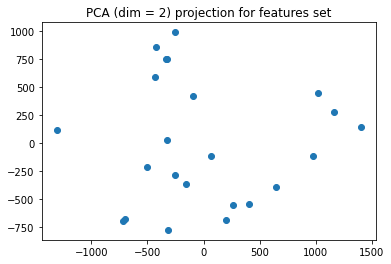

In [17]:
#@title 
def get_all_objects_and_descriptors():
  images = os.listdir('content')
  dict_features = {}
  all_descriptors = []
  for im in images:
    idxnokeep = []
    if '.tif' in im: continue

    loaded = imread(f"content/{im}")
    imgs, bbxs = generic_detector(loaded)
    dict_features[im] = {'bbxs_': bbxs, 'bbxs': []}
    dict_features[im]['descriptors'] = [] 

    for n, im_ in enumerate(imgs):
      dsc = descriptor(im_)
      if type(dsc) == type(None):
        idxnokeep.append(n)
        continue

      dict_features[im]['descriptors'].append(dsc)
      all_descriptors.append(dsc)
    for i in idxnokeep:
      dict_features[im]['bbxs_'][i] = None
    for bbx in dict_features[im]['bbxs_']:
      if bbx: dict_features[im]['bbxs'].append(bbx)
  
  return dict_features, all_descriptors

features, descriptors = get_all_objects_and_descriptors()
pca = PCA(2)
projection = pca.fit_transform(descriptors)
plt.scatter(projection[:, 0], projection[:, 1])
plt.title('PCA (dim = 2) projection for features set')
plt.show()

In [18]:
#@title
classifiers = [KMeans(3)]

A continuació, utilitzem un clasificador basat en [K-Means](https://en.wikipedia.org/wiki/K-means_clustering) que divideix l'espai  de característiques en tres categories de la següent forma:

Resulting Embedding Space with KMeans(n_clusters=3) clustering


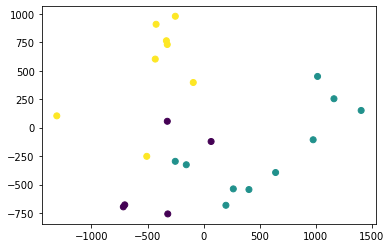

In [19]:
#@title
def classify(classifier, features, descriptors):
  model = classifier.fit(descriptors)
  colors = {0: (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)),
            1: (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)),
            2: (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))}
  pca = PCA(2)
  projection = pca.fit_transform(descriptors)
  projection_labels = model.predict(descriptors)
  print(f"Resulting Embedding Space with {classifier} clustering")
  plt.scatter(projection[:, 0], projection[:, 1], c = projection_labels)
  plt.show()

  images = []
  for img in features:

    img_loaded = imread('content/' + img)
    img_loaded = cv2.cvtColor(img_loaded, cv2.COLOR_GRAY2RGB)

    for bbx, dsc in zip(features[img]['bbxs'], features[img]['descriptors']):
      if type(bbx) != type(None):
        category = model.predict([dsc])[0]
        cv2.rectangle(img_loaded, (bbx[2], bbx[0]), (bbx[3], bbx[1]), colors[category], 5)
        cv2.putText(img_loaded, f"{category}", (bbx[2], bbx[0]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, colors[category], 2)
    images.append(img_loaded)
  return images
images = classify(classifiers[0], features, descriptors)

Aquestes categories es poden visualitzar sobre les imatges, idealment hauroen de compartir informació visual; lo qual no implica correspondència semàntica tot i que estigui altament correlacionat.
Explora la galeria d'imatges i valora els resultats.

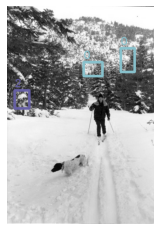

In [20]:
index = 4 #@param {type:"slider", min:0, max:6, step:1}
visualize_image(images[index])

### Preguntes:

* Quines limitacions trobes que hi ha en aquest catàleg?

Llegeix i investiga sobre la idea d'error de variància vs l'error d'esbiaixament (bias/variance tradeoff). ([link 1](https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229),  [link 2](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff))

* Creus que les limitacions del sistema son errors d'alta variància o d'alt esbiaixament? Com s'ha provocat aquest error?

In [21]:
#@title 
def classify(classifier, features, descriptors):
  feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
  model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

  images = []
  for img in features:

    img_loaded = imread('content/' + img)
    img_loaded = cv2.cvtColor(img_loaded, cv2.COLOR_GRAY2RGB)

    img_PIL = Image.fromarray(img_loaded)

    inputs = feature_extractor(images=img_PIL, return_tensors="pt")
    outputs = model(**inputs)

    target_sizes = torch.tensor([img_PIL.size[::-1]])
    results = feature_extractor.post_process(outputs, target_sizes=target_sizes)[0]

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [int(round(i, 2)) for i in box.tolist()]
        # let's only keep detections with score > 0.9
        if score > 0.9:
          cv2.rectangle(img_loaded, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 5)
          cv2.putText(img_loaded, f"{label} - {round(float(score.detach().item()), 2)}", (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    images.append(img_loaded)
  return images
images = classify(classifiers[0], features, descriptors)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


El següent mètode per catalogar fotografies es basa en Xarxes Neuronals, una idea que veurem en posteriors sessions. Aquestes es basen en rebre una gran quantitat d'imatges (normalment, aquesta quantitat pot variar de l'ordre de les desenes de milers fins els milions, depenent la tasca) i optimitzar les mètriques establertes en comú per a totes les dades del conjunt d'entrenament.

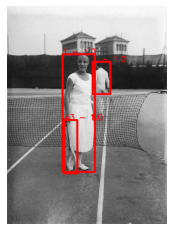

In [22]:
index = 1 #@param {type:"slider", min:0, max:6, step:1}
visualize_image(images[index])

### Preguntes 
* Amb la breu descripció anterior, per qué creus que aquest métode funciona millor que l'anterior?
* Pots trobar una relació entre la millora d'aquest mètode i l'error (variancia o esbiaixament) del mètode anterior?